In [67]:
import numpy as np
import matplotlib.pyplot as plt 
from numba import jit

In [68]:
# Parameters 
L = 1  # length of the domain
T = 1E-2  # total time
nx = 100  # number of spatial points
nt = 300  # number of time steps

dx = L / nx
dt = T / nt

x = np.linspace(0, L, nx)

In [69]:
# Potential initial conditions 
V0 = 2*(np.pi * 50)**2  # potential strength
a = 0.032  # width
V = np.zeros(nx)
V[int((nx - a * nx) / 2):int((nx + a * nx) / 2)] = V0 # indices for start and end of the well 

In [70]:
# Gaussian wave packet
x0 = L / 4  # center of the wave packet
k0 = 2 * np.pi * 50 #2*np.sqrt(V0) #(L / 2*T) / 2 #np.pi * 50 # # wave number of the wave packet (p = hbar*k)
sigma = L / 20  # width of the wave packet
gaussian = np.exp(-0.5 * ((x - x0) / sigma) ** 2)
phase = np.exp(-1j * k0 * x)
psi0 = gaussian * phase

In [71]:
# Build coefficient matrix, a+
aplus = np.zeros((nx, nx),complex)
nu = 1j * dt / (4 * dx**2) # kinetic energy operator

for i in range(len(aplus) - 1): # off diagonal 
    aplus[i,i+1] = aplus[i+1,i] = -nu 

for i in range(len(aplus)): # diagonal
    aplus[i,i] = 1 + 2 * nu #* V[i] / 2 

aplus_inv = np.linalg.inv(aplus)


In [72]:
# Build coefficient matrix, a-
aminus = np.zeros((nx, nx),complex)

for i in range(len(aminus)-1): # off diagonal 
    aminus[i,i+1] = aminus[i+1,i] = nu # kinetic energy term which contribute to the spatial derivative but not the potential 

for i in range(len(aminus)): # diagonal
    aminus[i,i] = 1 - 2 * nu #* V[i] / 2  # potential energy term which affect the wavefunction at each spatial point 

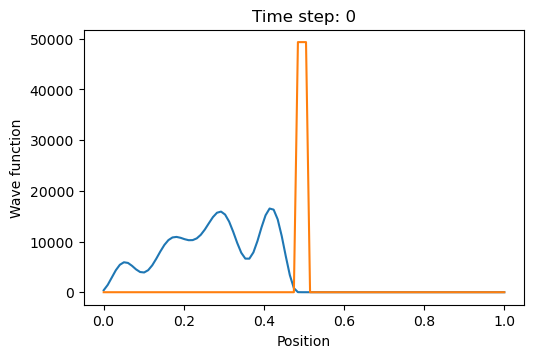

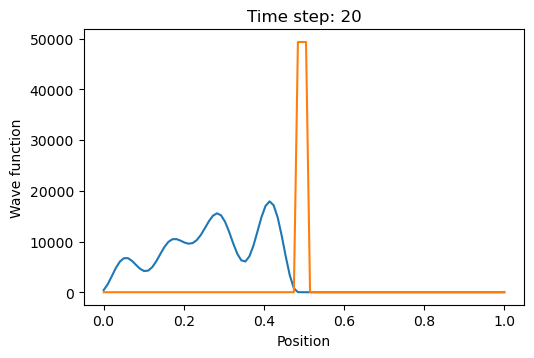

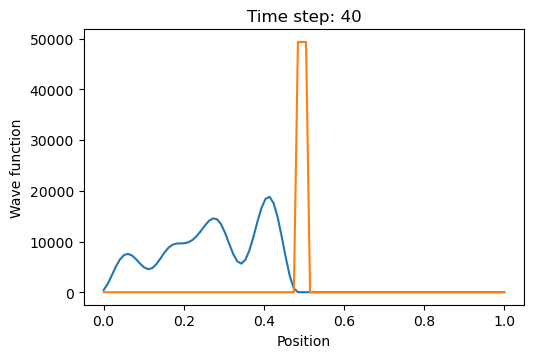

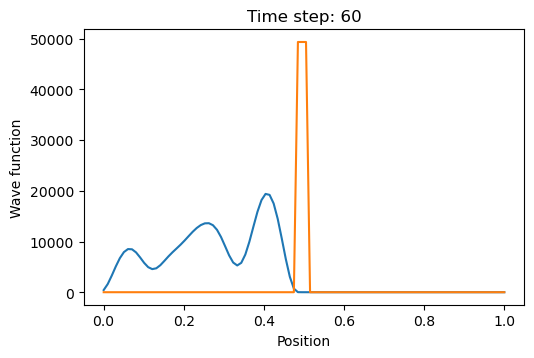

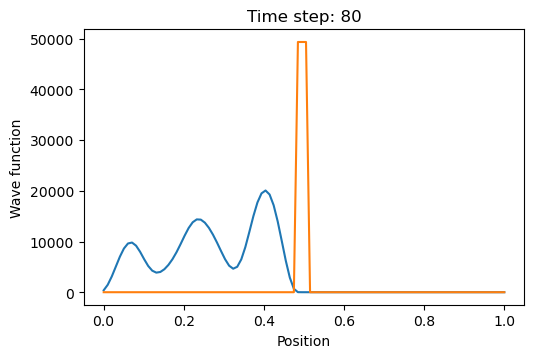

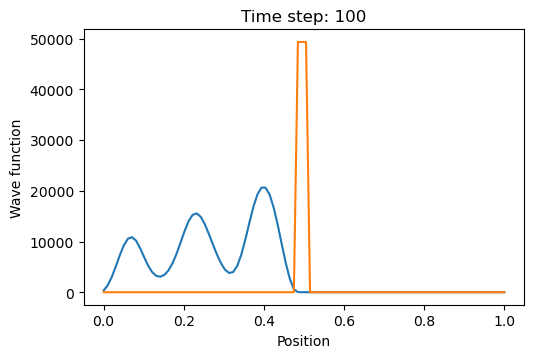

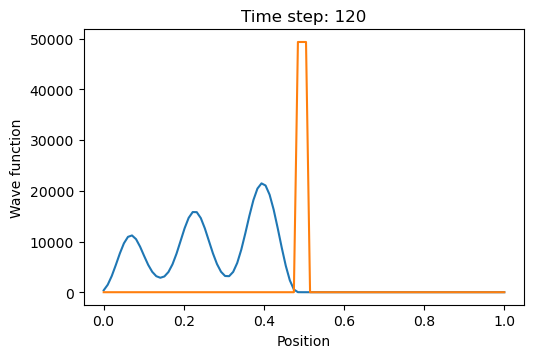

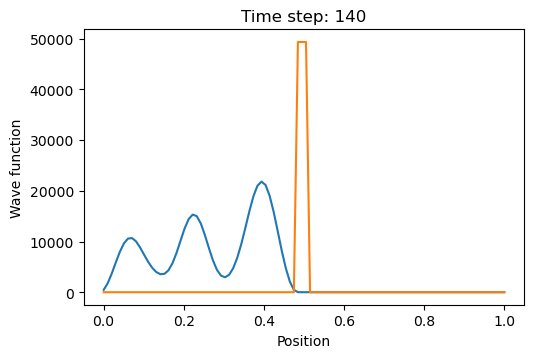

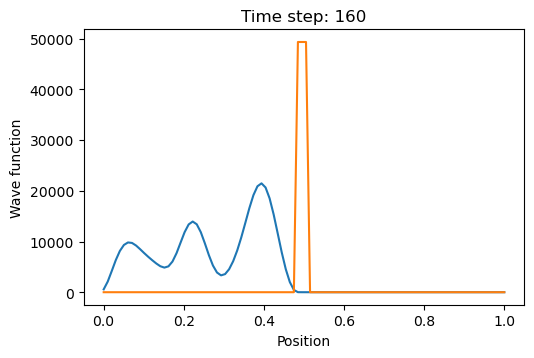

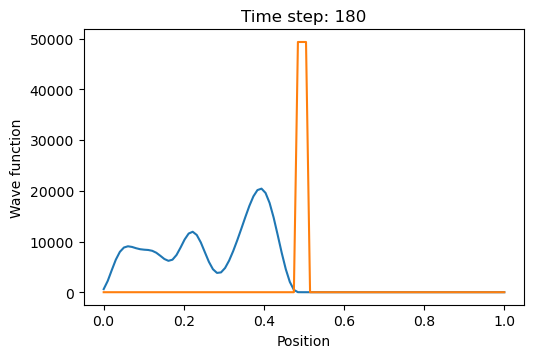

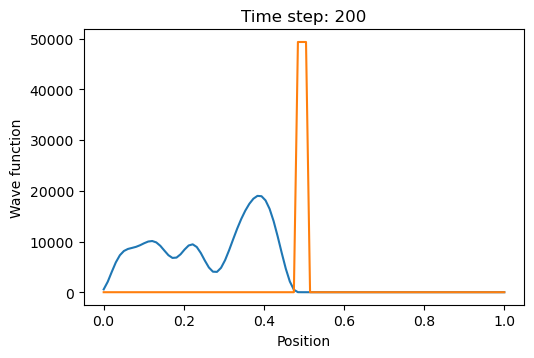

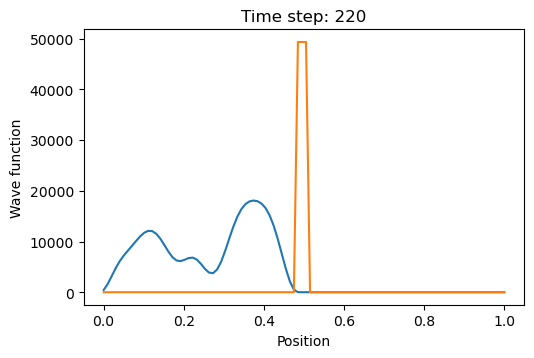

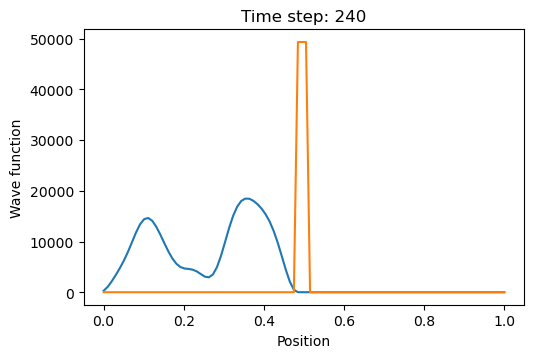

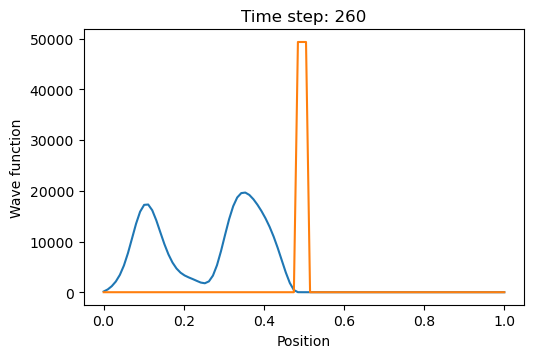

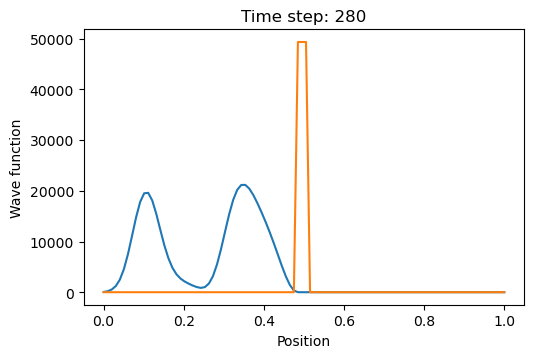

In [75]:
# Crank-Nicholson
for t in range(nt):
    f = np.exp(-1j * dt * V) * psi0
    psi = np.dot(aplus_inv, np.dot(aminus, f))
    psi0 = psi

    # plotting 
    if t % 20 == 0:
        # plt.plot(x, np.abs(psi))#, label=f'Time step: {t}')
        plt.figure(figsize=(10, 500))
        num_cols = 2  # Number of columns for subplots
        num_rows = (nt + num_cols - 1) // num_cols

        plt.subplot(num_rows, num_cols, t + 1)
        plt.plot(x, np.abs(psi)**2 * V0)
        plt.plot(x, V)
        plt.title(f'Time step: {t}')
        plt.xlabel('Position')
        plt.ylabel('Wave function')
        # plt.ylim(0, 1)
        plt.tight_layout()
        
        # plt.plot(x, f.real, 'real')
        # plt.plot(x, f.imag, 'imag')
        # plt.legend()

plt.show()

# plt.plot(x, V, label='Potential (V)')
# plt.xlabel('Position')
# plt.ylabel('Wave function')
# plt.title('Gaussian wave packet scattering (TDSE w/ CN)')
# plt.legend()
# plt.show()


In [ ]:
# Reflection and transmisison coefficients 
# R = abs(ref)**2 / abs(inc)**2
# T = abs(trans)**2 / abs(inc)**2
# R + T = 1

incident_end = int((nx - a * nx) / 2) # where potential starts 
reflected_start = 0
reflected_end = incident_end
transmitted_start = int((nx + a * nx) / 2) # where potential ends 
transmitted_end = nx

# Extract wavefunction segments for each region
incident_wavefunction = psi[0:incident_end]
reflected_wavefunction = psi[reflected_start:reflected_end]
transmitted_wavefunction = psi[transmitted_start:transmitted_end]

# Calculate reflection and transmission coefficients
R = np.sum(np.abs(reflected_wavefunction) ** 2) / np.sum(np.abs(incident_wavefunction) ** 2)
T = np.sum(np.abs(transmitted_wavefunction) ** 2) / np.sum(np.abs(incident_wavefunction) ** 2)

# Print the calculated coefficients
print(f"Reflection coefficient (R): {R}")
print(f"Transmission coefficient (T): {T}")


Reflection coefficient (R): 1.0
Transmission coefficient (T): 8800298.797111226


[ 2.68370253e-06-2.47262813e-06j -6.82963567e-06+7.25203958e-06j
  1.72512689e-05-1.90433018e-05j -4.18501955e-05+4.80658941e-05j
  9.72998807e-05-1.16455102e-04j -2.16787741e-04+2.70809055e-04j
  4.62812183e-04-6.04409681e-04j -9.46573377e-04+1.29462437e-03j
  1.85441153e-03-2.66122581e-03j -3.47914493e-03+5.24961618e-03j
  6.24960977e-03-9.93720663e-03j -1.07456107e-02+1.80499420e-02j
  1.76795771e-02-3.14591101e-02j -2.78237912e-02+5.26091345e-02j
  4.18673816e-02-8.44122398e-02j -6.02038142e-02+1.29946644e-01j
  8.26772099e-02-1.91922649e-01j -1.08348280e-01+2.71941356e-01j
  1.35365346e-01-3.69656748e-01j -1.61027156e-01+4.82039782e-01j
  1.82090487e-01-6.02996009e-01j -1.95307716e-01+7.23568401e-01j
  1.98095361e-01-8.32845357e-01j -1.89165643e-01+9.19505675e-01j
  1.68932245e-01-9.73721791e-01j -1.39547129e-01+9.88986469e-01j
  1.04529017e-01-9.63395501e-01j -6.80706780e-02+9.00037547e-01j
  3.42133876e-02-8.06381045e-01j -6.11311012e-03+6.92826349e-01j
 -1.44183250e-02-5.708108

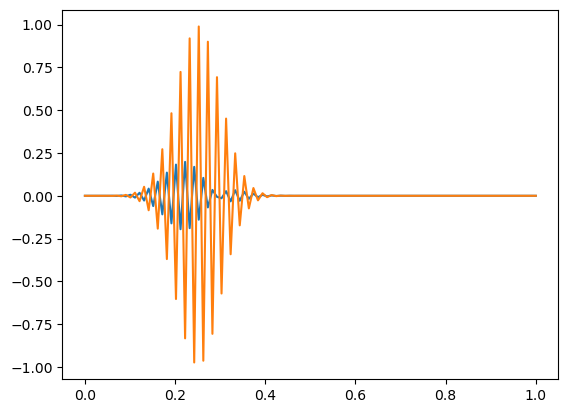

In [ ]:
f = np.exp(-1j * dt * V) * psi0
print(f)
# plt.plot(x, V)
plt.plot(x, f.real)
plt.plot(x, f.imag)
plt.show()